
MCTA 4362: Machine Learning

Mini Project - Facial Expression Recognition and Analysis

Name: **NOORUL GHOUSIAH BINTI NOORDEEN SAHIB**   Matric No: **2118298**

Name: **NURAIN AINAA AQILAH BINTI ROSLI**   Matric No: **2114650**

# **Import library**

In [23]:
#!pip uninstall tf-keras -y

In [24]:
# Import necessary libraries
import numpy as np
import os
from google.colab import drive


# Check and optionally upgrade TensorFlow
import tensorflow as tf

# Check if the TensorFlow version is different from 2.15.1
if tf.__version__ != '2.15.1':
    # Use os.system to run the pip install command
    os.system('pip install tensorflow==2.15.1')
    # Re-import TensorFlow after upgrading
    import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pickle
from google.colab import files


# **Load model, training data, and images.** **Get X_train and X_test**

In [26]:
# Load PCA object from a file using pickle
pca_filename = 'pca_modelall256.pkl'
with open(pca_filename, 'rb') as f:
    pca = pickle.load(f)

print("PCA model loaded successfully.")

# Load the transformed training data from the files
with open('X_train_pca.pkl', 'rb') as f:
    X_train_pca = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)


print("Data loaded successfully.")

PCA model loaded successfully.
Data loaded successfully.


In [27]:
# Mount Google Drive
drive.mount('/content/drive/')

# Define the data generator with normalization
datagen = ImageDataGenerator(rescale=1./255)

# Define the directory for your dataset
test_data_dir = '/content/drive/My Drive/Colab Notebooks/MCTAmachinelearning/MachineLearningFacialExpression/Facial_Expression_Dataset/testnew'    # Replace with your actual path #Ghousiah's Lappy



# Verify the directory exists
if os.path.exists(test_data_dir):
    print("Directory exists. Proceeding...")
else:
    print("Error: Directory not found. Please check the path.")

# Create the validation generator
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=14,
    class_mode='categorical',
    shuffle=False # Shuffle the data to ensure randomness
)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Directory exists. Proceeding...
Found 14 images belonging to 1 classes.


In [28]:
# Transform training and test data using PCA
def transform_with_pca(generator, pca):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        inputs_batch = inputs_batch.reshape(inputs_batch.shape[0], -1)
        features_batch = pca.transform(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if generator.batch_index == 0:  # If we've looped back to the start
            break
    return np.vstack(features), np.vstack(labels)

# Extract features using PCA for training and testing
# Transform training data and test data using PCA
X_test_pca, y_test = transform_with_pca(test_generator, pca)


with open('X_test_pca.pkl', 'wb') as f:
    pickle.dump(X_test_pca, f)


# Print shapes of transformed data
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_train_pca: (28687, 256)
Shape of y_train: (28687,)
Shape of X_test_pca: (14, 256)


# **Standardisation**

In [29]:
X_train = X_train_pca
X_test = X_test_pca

# Standardize the PCA-transformed data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
print(X_test)

[[ 0.09552573 -2.8099337  -1.0653279  ...  0.25874448 -0.50970304
  -0.6761991 ]
 [ 1.346219   -1.04549    -0.78735197 ...  1.63241     0.60069484
   1.4368885 ]
 [-0.2538071   0.6526521   0.17411396 ...  0.34184396  1.6166738
   1.1052847 ]
 ...
 [ 0.4445306  -0.52036303  0.294651   ...  1.6102741   0.9404535
  -0.59129745]
 [ 0.2813544  -0.78790927  1.5574176  ... -0.3385688  -1.2502089
   0.14990653]
 [ 0.958121   -1.1271988  -0.34170198 ... -0.31655976 -0.4819028
  -0.35728627]]


# **Kmeans**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from collections import Counter


In [32]:
# K-Means clustering
#n_clusters = 7  # Number of clusters (e.g., for 7 facial expressions)
#kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#kmeans.fit(X_train_pca)

with open('kmean.pkl', 'rb') as f:
    kmeans = pickle.load(f)

# Get cluster memberships for training and test data
train_clusters = kmeans.predict(X_train_pca).reshape(-1, 1)
test_clusters = kmeans.predict(X_test_pca).reshape(-1, 1)

# Combine original features with cluster memberships

X_train_combined = np.hstack((X_train_pca, train_clusters))
X_test_combined = np.hstack((X_test_pca, test_clusters))

X_train = X_train_combined
X_test = X_test_combined

# Print shapes of transformed data
print("Shape of X_train_pca:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test_pca:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_pca: (28687, 257)
Shape of y_train: (28687,)
Shape of X_test_pca: (14, 257)
Shape of y_test: (14, 1)


# **Supervised Classification**

**load saved SVM Train model**

In [33]:
# Load the SVM model
from sklearn.svm import SVC

with open('nonlinear_svm_model.pkl', 'rb') as f:
    nonlinsvm = pickle.load(f)

**Predict Test Set Result**

In [34]:
y_pred_nlsvm = nonlinsvm.predict(X_test)

print("Predicted Output (Categorical):")
print(y_pred_nlsvm)

Predicted Output (Categorical):
[3 5 4 3 6 2 4 3 0 5 1 0 3 3]


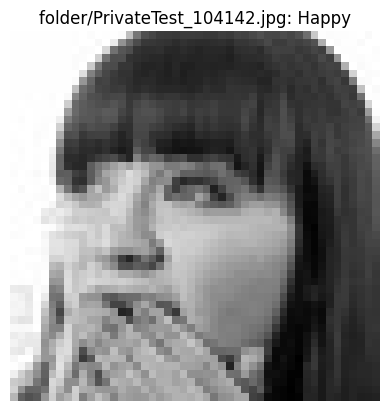

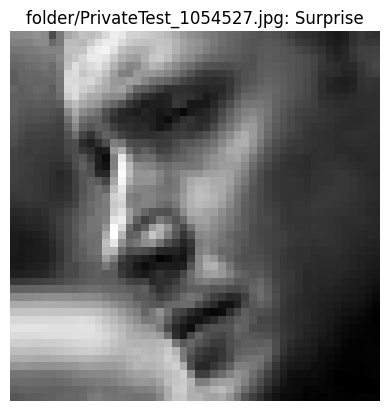

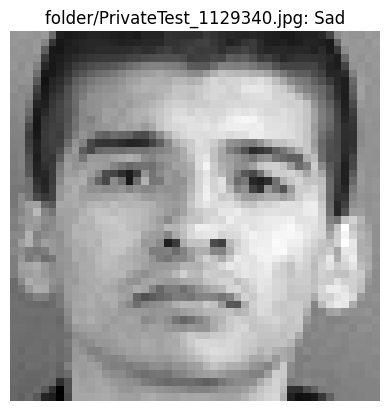

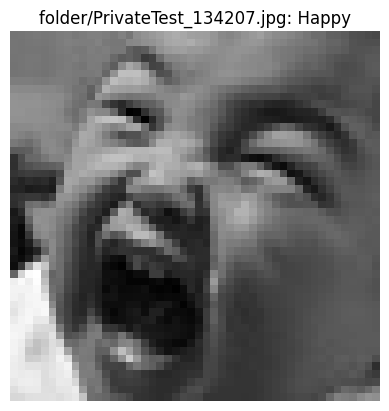

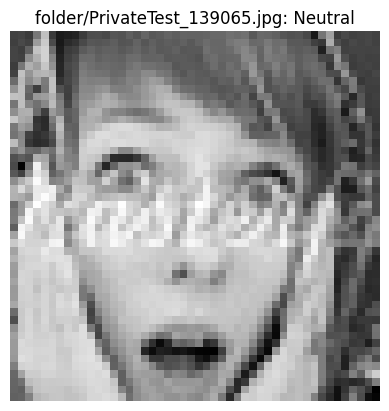

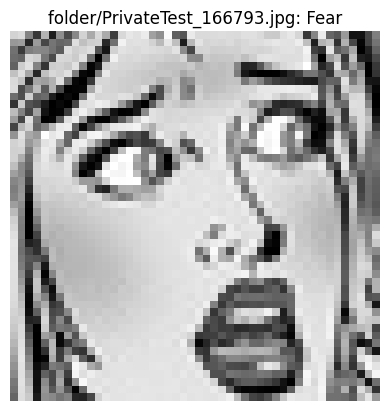

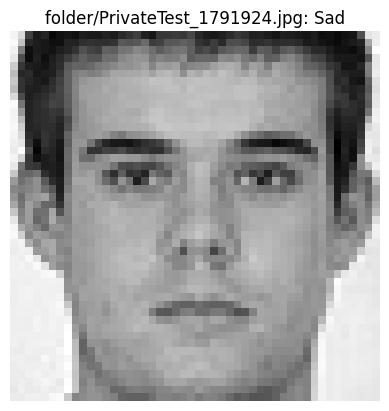

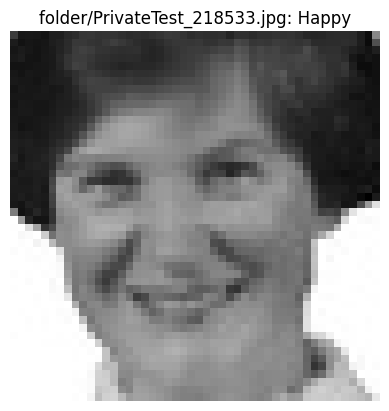

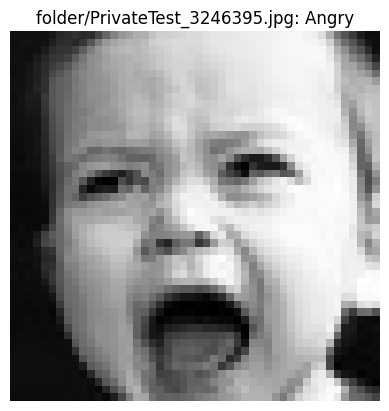

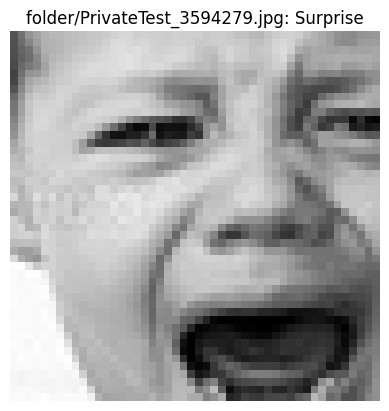

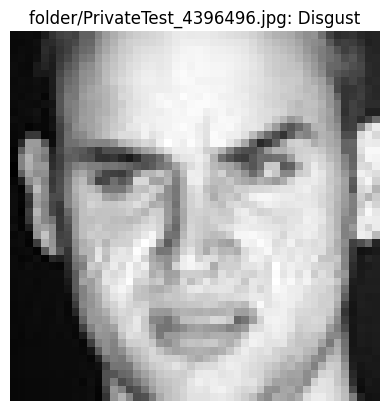

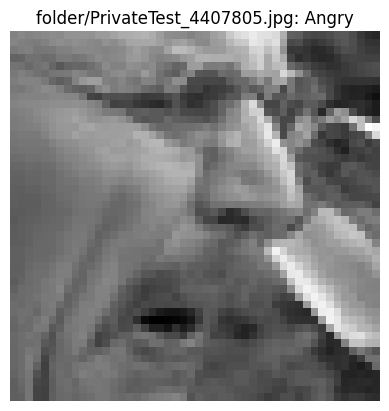

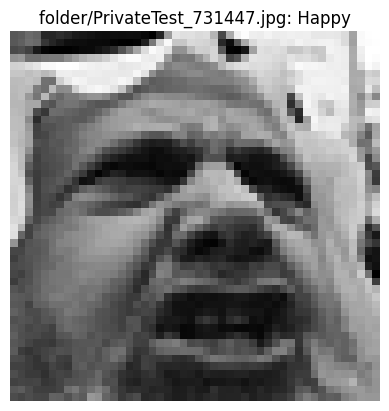

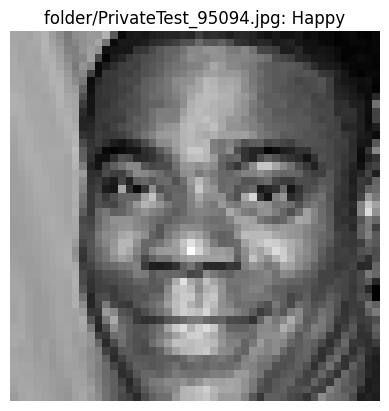

In [35]:
from PIL import Image
image_names = test_generator.filenames

# Define emotion labels (update based on your dataset)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Display images with their predicted emotions
for image_name, prediction in zip(image_names, y_pred_nlsvm):
    img_path = os.path.join(test_data_dir, image_name)
    img = Image.open(img_path).convert('L')
    plt.imshow(img, cmap='gray')
    plt.title(f"{image_name}: {emotion_labels[prediction]}")
    plt.axis('off')
    plt.show()